In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 61kB/s 
     |████████████████████████████████| 204kB 46.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=936f18019b2bd0a149775f34934717e1af0708450dc8cd8d65785b96099f3183
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
import tweepy
from tweepy import OAuthHandler
import csv
import time
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
from pyspark.sql import Row
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [ ]:
consumer_key = 'c4cK1xqfC3MocKF4gPwE0vHFH'
consumer_secret = 's6T5kM503GQ49mE2ZRNNUtz7VRTNCqHsox1gVOPRFmSv5CHwSV'
access_token = '1244402689175420929-BilxLAuVQotLB4HMAWuECgnuCQewmY'
access_secret = 'sm8ygnOT7Xzjb2iaZL95yR5oPWpJQKIwu7PNgBs8BOnRJ'

auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

query = '#BlackLivesMatter'
max_tweets = 10000
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query, lang='en').items(max_tweets)]

In [ ]:
len(searched_tweets)

2500

In [ ]:
queried_tweetext = []
for tweets in searched_tweets:
    queried_tweetext.append(tweets.text)

In [ ]:
#Creating Spark Dataframe of tweets
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

rdd = sc.parallelize(queried_tweetext)
row_rdd = rdd.map(lambda x: Row(x))

spark_df = sqlContext.createDataFrame(row_rdd,['Tweets'])

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark_df = spark_df.withColumn("Hashtags", regexp_extract(spark_df.Tweets, r"#(\w+)",1))
spark_df = spark_df.withColumn("Tweet_content", regexp_replace(spark_df.Tweets, r"[^a-zA-Z\. ]",""))

In [ ]:
spark_df.show(5)

+--------------------+----------------+--------------------+
|              Tweets|        Hashtags|       Tweet_content|
+--------------------+----------------+--------------------+
|Pelosi has introd...|BlackLivesMatter|Pelosi has introd...|
|RT @ajplus: A pro...|BlackLivesMatter|RT ajplus A promi...|
|Isn't the Nationa...|BlackLivesMatter|Isnt the National...|
|RT @Quicktake: “I...|                |RT Quicktake Its ...|
|RT @JamaalBowmanN...|BlackLivesMatter|RT JamaalBowmanNY...|
+--------------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import RegexTokenizer

tokenizer = RegexTokenizer().setInputCol('Tweet_content').setOutputCol('words')
tokenized_df = tokenizer.transform(spark_df)

tokenized_df.select('Tweet_content', explode('words').alias('word')).show(5)

+--------------------+----------+
|       Tweet_content|      word|
+--------------------+----------+
|Pelosi has introd...|    pelosi|
|Pelosi has introd...|       has|
|Pelosi has introd...|introduced|
|Pelosi has introd...|       and|
|Pelosi has introd...|    passed|
+--------------------+----------+
only showing top 5 rows



#Topic modelling
We will use Latent Dirichlet Allocation, or LDA, for topic modelling. 

One can think of topic modelling as an unsupervised clustering technique. Given a corpus of documents, in this case, a corpus of Wikipedia comments, the algorithm (here, LDA) tries to find the latent factors or topics based on the words. LDA will not see the labels. It will be interesting to see if LDA can actually segregate the comments into clean and toxic comments, and furthermore find the substructures in the levels of toxicity.

Please note that there is no guarantee that LDA topics will be human interpretable.

We will first prepare the dictionary and the corpus for gensim's LDA module. It's fairly straightforward, you first create a dictionary of all the tokens (basically means that you map each token to a unique number) and then create a bag of words model with word counts. This will constitute the corpus.

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, HTML

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
#Collecting the text contained in tweets

tweet_text = [val.Tweet_content for val in tokenized_df.select('Tweet_content').collect()]

In [ ]:
#Removing stopwords and Lemmatization

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 

def get_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_comment(input_str):
    
    comment=re.sub(r"(\d{1,3}\.){1,3}\d{1,3}","",input_str)  #remove ip's
    words = [word for word in tokenizer.tokenize(comment.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word,pos = get_pos(word)) for word in words if len(word)>2]) ## lemmatization
    return lemmatized_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
cleaned_tweets = [preprocess_comment(tweets) for tweets in tweet_text]

In [ ]:
nltk.download('punkt')
tokenized_tweet = [word_tokenize(doc) for doc in tweet_text]
gensim_dict = Dictionary(tokenized_tweet)
gensim_dict.save('dictionary.dict')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Now convert each document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_tweet]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)



In [ ]:
num_topics=5
start = time.time()
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics,chunksize=2000, random_state=42)
#lda.save('lda_5_topics.ldamodel')
print((time.time() - start)/60, 'mins')

0.02695651849110921 mins


### Visualising the topics

In [ ]:
def show_topics(model,num_topics=5):
    topics = {}
    for i in range(num_topics):
        topics[i] = [tup[0] for tup in model.show_topic(i)]
    topics_lda_df = pd.DataFrame(data=topics)
    topics_lda_df.columns = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']
    return topics_lda_df

show_topics(lda,num_topics=5)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,RT,you,RT,to,RT
1,BlackLivesMatter,President.Didnt,BlackLivesMatter,RT,a
2,couldve,RT,the,.,and
3,too,was,of,the,.
4,my,BlackLivesMatter,.,BlackLivesMatter,is
5,say,say,amp,and,BlackLivesMatter
6,JamaalBowmanNY,been,In,a,the
7,son,much.In,The,is,was
8,In,In,a,in,from
9,Trayvon,Mr.,we,for,in


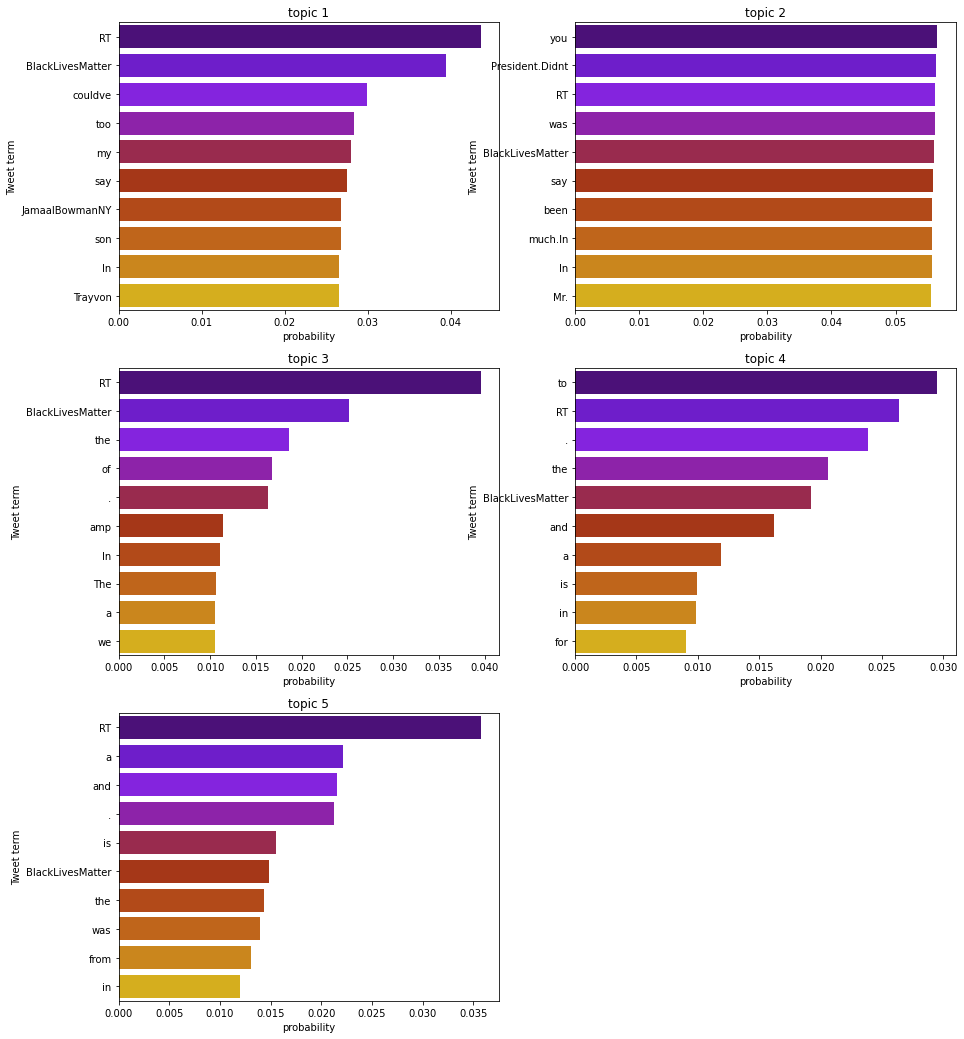

In [ ]:
fig=plt.figure(figsize=(15,18))
for i in range(num_topics):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(3,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, palette='gnuplot')
    plt.xlabel('probability')
    plt.ylabel('Tweet term')

## LDA with tf-idf features

In [ ]:
from gensim import models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
num_topics=5
start = time.time()
lda_tfidf = LdaModel(corpus_tfidf, id2word=gensim_dict, num_topics=num_topics, chunksize=2000,random_state=42)
print((time.time() - start)/60, 'mins')

0.020474112033843993 mins


In [ ]:
topics_tfidf = show_topics(lda_tfidf,num_topics=5)
topics_tfidf

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,couldve,President.Didnt,Damn,to,President.Didnt
1,Trayvon,much.In,In,johncardillo,much.In
2,son,Trayvon,son,happened,Mr.
3,JamaalBowmanNY,Mr.,Trayvon,Antifa,couldve
4,Damn,son,Mr.,What,son
5,Mr.,Damn,JamaalBowmanNY,and,JamaalBowmanNY
6,much.In,couldve,much.In,.,Damn
7,say,JamaalBowmanNY,couldve,is,Trayvon
8,President.Didnt,been,been,the,been
9,been,say,too,in,say


###Visualizing the topics with PyLDAvis

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 12.7MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=de588dfa3ba48fbe13594a5d4a09b3b41cb40637ec13c96bf7eb3ef765002f5d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [ ]:
start = time.time()
lda_display = pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, gensim_dict)
end = time.time()
print((end-start)/60,'mins')

0.05176179806391398 mins


In [ ]:
pyLDAvis.display(lda_display)

###########################################################################


In [ ]:
from pyspark.sql.functions import lit

neg=sc.textFile("/content/negative-words.txt")
temp_var = neg.map(lambda k: k.split("\\t"))
neg_df = temp_var.toDF()
neg_df= neg_df.withColumn('sentiment',lit(-1))

### positive words
pos=sc.textFile("/content/positive-words.txt")
temp_var_pos = pos.map(lambda k: k.split("\\t"))
pos_df = temp_var_pos.toDF()
pos_df= pos_df.withColumn('sentiment',lit(1))

#### concat both
words_concat = pos_df.union(neg_df)
columns = ['word','sentiment']
words = words_concat.toDF(*columns)
words.show(5)

+---------+---------+
|     word|sentiment|
+---------+---------+
|       a+|        1|
|   abound|        1|
|  abounds|        1|
|abundance|        1|
| abundant|        1|
+---------+---------+
only showing top 5 rows



In [ ]:
#Joining tweets with Liu Bing word sets to obtain the sentiment of each word

join_df = tokenized_df.\
    select('Tweet_content', F.explode('words').alias('word')).\
    join(words, 'word')
join_df.show(10)

+------------+--------------------+---------+
|        word|       Tweet_content|sentiment|
+------------+--------------------+---------+
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
|inflammatory|RT LRPow In jest ...|       -1|
+------------+--------------------+---------+
only showing top 10 rows



In [ ]:
#Grouping sentiments by tweets and using sum of the sentiments as score
score_df = join_df.\
    groupBy('Tweet_content').\
    agg(F.sum('sentiment').alias('Sentiment_score'))

score_df.sort(F.col('Sentiment_score').desc()).show(5)

+--------------------+---------------+
|       Tweet_content|Sentiment_score|
+--------------------+---------------+
|RT KingJames This...|             57|
|RT ESPNcricinfo W...|             40|
|RT Inhumansoflate...|             26|
|RT RichardKomolaf...|             22|
|RT GadZook Its ea...|             18|
+--------------------+---------------+
only showing top 5 rows



In [ ]:
final_tweets = tokenized_df.\
    select(F.col('Tweets'),F.col('Hashtags'),F.col('Tweet_content')).\
    join(score_df, 'Tweet_content',)

In [ ]:
final_tweets.select('Tweets','Sentiment_score','Hashtags').distinct().sort(F.col('Sentiment_score').desc()).show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------------+
|Tweets                                                                                                                                       |Sentiment_score|Hashtags        |
+---------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------------+
|RT @KingJames: This Queen was such a huge part of @Morethanavote.  So great to see her being recognized for changing the world.  #Blacklive… |57             |Blacklive       |
|RT @ESPNcricinfo: West Indies captain Jason Holder is pleased with the support that New Zealand have shown for #BlackLivesMatter and the fi… |40             |BlackLivesMatter|
|RT @Inhumansoflate1: Oh here’s Biden’s new openly fascist we  cabinet member . glad you voters got rid of the fasc

In [ ]:
cluster_df = final_tweets.select('Hashtags','Sentiment_score').distinct().sort(F.col('Sentiment_score'))

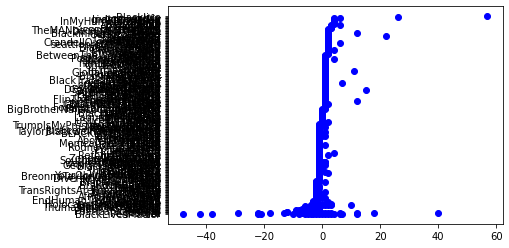

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#htags = np.array([val.Hashtags for val in cluster_df.select('Hashtags').collect()])
#scores_sent = np.array([val.Sentiment_score for val in cluster_df.select('Sentiment_score').collect()])

htags = [val.Hashtags for val in cluster_df.select('Hashtags').collect()]
scores_sent = [val.Sentiment_score for val in cluster_df.select('Sentiment_score').collect()]

#Pop based on outliers found to get a better image.
htags.pop(0)
scores_sent.pop(0)
htags.pop(0)
scores_sent.pop(0)
htags.pop(0)
scores_sent.pop(0)

plt.plot(scores_sent, htags, 'bo')
plt.show()

In [ ]:
scores_scaled = np.interp(np.array(scores_sent), (np.array(scores_sent).min(), np.array(scores_sent).max()), (-10,+10))

plt.plot(scores_scaled, htags, 'bo')
plt.show()